# Contest rating change prediction for user using KNN algorithm.

We will try to predict rating change based on previous contests - duration, authors, contest beginning hour, previous performances of the user and ratings.

## Imports

In [1]:
from database import *
import numpy as np
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt

## Helpers, variables, loading data

In [2]:
def load_database():
    db = LoadDatabase()
    
    user_history = {}
    for contestId, standings in tqdm(sorted(db.standings.items(), key=lambda x: db.contests.loc[x[0]].startTime)):
        for handle, row in standings.iterrows():
            if not handle in user_history:
                user_history[handle] = {key: [] for key in row.keys()}
                user_history[handle]["contestId"] = []
            for key, value in row.items():
                user_history[handle][key].append(value)
            user_history[handle]["contestId"].append(contestId)
            
    for handle, history in tqdm(user_history.items()):
        db.history[handle] = pd.DataFrame(history)
        cols = sorted(db.history[handle].columns)
        db.history[handle] = db.history[handle][cols]
        
    return db

In [3]:
db = load_database()

100%|██████████| 278681/278681 [05:13<00:00, 888.15it/s] 


In [10]:
def get_users(threshold=50, fraction=1):
    all_users = [handle for handle, history in db.history.items() if len(history) >= threshold]
    n = max(1, int(fraction * len(all_users)))
    return np.random.choice(all_users, n, replace=False)

def get_random_user(threshold=50):
    return np.random.choice(get_users(threshold=threshold))

def get_correlation(user, author):
    if not author in db.history:
        return 0
    if not user in db.history:
        return 0
    
    user_history = db.history[user].set_index("contestId")
    author_history = db.history[author].set_index("contestId")
    common_contests = 0
    scalar_sum = 0
    
    for contestId in user_history.index:
        if not contestId in author_history.index:
            continue
    
        common_contests += 1
        scalar_sum += author_history.loc[contestId].delta * user_history.loc[contestId].delta
    
    if common_contests == 0:
        return 0
    if common_contests == 1:
        return scalar_sum / 5000
    if common_contests == 2:
        return scalar_sum / 500
    return scalar_sum / (common_contests ** 0.5)

user_datas = {}
def get_user_data(handle=None, threshold=50):
    if handle is None:
        handle = get_random_user(threshold=threshold)
    if handle in user_datas:
        return user_datas[handle]
    
    user_history = db.history[handle].iloc[1:].reset_index().drop("index", axis=1)
    user_history.delta = user_history.newRating - user_history.oldRating
    # user_history.delta = user_history.delta.map(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    user_contests = db.contests.loc[user_history.contestId]
    user_history["dayTime"] = user_contests.reset_index().dayTime
    user_history["startTime"] = user_contests.reset_index().startTime
    user_history["duration"] = user_contests.reset_index().duration
    user_history["authors"] = user_contests.reset_index().authors
    user_history["author"] = user_contests.reset_index().authors.map(lambda x: list(x)[0] if len(x) > 0 else "")
#     user_history["correlation"] = user_history.author.map(lambda x: get_correlation(x, handle))
    user_history["correlation"] = user_history.authors.map(lambda x: np.mean([get_correlation(a, handle) for a in x]) if len(x) > 0 else 0)
    user_datas[handle] = user_history
    
    return user_history

def get_Xy(handle=None, threshold=50):
    user_data = get_user_data(handle=handle, threshold=threshold)
    X_columns = ["oldRating", "dayTime", "duration", "startTime", "correlation"]
    y_columns = ["delta"]
    X, y = user_data[X_columns], user_data[y_columns]
    std = X.std()
    std[std == 0] = 1
    X = (X - X.mean()) / std
    return X, y

def get_train_test(handle=None, threshold=50):
    X, y =  get_Xy(handle=handle, threshold=threshold)
    X_train, y_train = X.iloc[:-1], y.iloc[:-1]
    X_test, y_test = X.iloc[-1:], y.iloc[-1:]
    return X_train, X_test, y_train, y_test

## User contest history

In [8]:
db.history["tourist"].head()

,contestId,delta,newRating,oldRating,rank
0,28,30,2128,2098,11
1,33,75,2203,2128,1
2,37,53,2256,2203,3
3,40,41,2311,2270,1
4,42,30,2341,2311,1


## Contest data

In [18]:
db.contests.head()

,duration,startTime,dayTime,authors
id,,,,
1471,7200,1609857300,52500,"{fastmath, Mangooste, Karabutsa, scanhex, cdkr..."
1470,7200,1609857300,52500,"{fastmath, Mangooste, Karabutsa, scanhex, cdkr..."
1467,7200,1610116500,52500,"{alimq, DS007}"
1466,10800,1609338900,52500,"{gawry, Anadi, Okrut}"
1465,7200,1608476700,54300,"{dargelirli, neckbotov}"


This is how user contest history looks like.

## Data we are analyzing (normalized)

In [14]:
X_train, X_test, y_train, y_test = get_train_test()
pd.concat((X_train, y_train), axis=1).head()

,oldRating,dayTime,duration,startTime,correlation,delta
0,-2.331446,0.084390,-0.303723,-1.531270,-0.249928,25
1,-2.085367,0.084390,-0.303723,-1.521647,-0.101478,84
2,-1.258542,0.084390,-0.303723,-1.512024,0.211461,12
3,-1.140424,0.331067,-0.303723,-0.703654,-0.180448,-92
4,-2.045995,0.331067,-0.303723,-0.691282,-0.890246,142


## Prepare data

In [5]:
threshold = 50 # min number of contest for user to have
users = get_users(threshold=threshold, fraction=0.1) # users to consider

We will try to just predict if delta of rating after contest will be positive, negative or zero (classification problem).

## Random classifier

Just randomly say delta is negative, positive or the same.

In [457]:
score, total = 0, 0
for handle in tqdm(users):
    X_train, X_test, y_train, y_test = get_train_test(handle=handle)
    predictions = np.random.uniform(-1, 1, size=y_test.shape)
    score += np.sum(np.sign(predictions) == np.sign(y_test))
    total += y_test.shape[0]
print("Random Acuraccy:", score / total, "score:", score, "total:", total)

100%|██████████| 867/867 [00:05<00:00, 152.47it/s]

Random Acuraccy: delta    0.477509
dtype: float64 score: delta    414
dtype: int64 total: 867


We can see tha random classifier classifies pretty randomly $\approx 50\%$.

## Greedy classifiers

Say that delta is the same as the mode in the $x$ last contests.

In [556]:
import scipy.stats as sstats

go_backs = list(range(5))
greedy_errors = []

for go_back in go_backs:
    score, total = 0, 0
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        deltas = np.sign(y_train[-go_back:])
        predictions = sstats.mode(deltas)[0]
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    greedy_errors.append((total - score) / total)
    clear_output()

100%|██████████| 867/867 [00:05<00:00, 163.78it/s]


Best go_back: 0 error: 0.4728950403690888


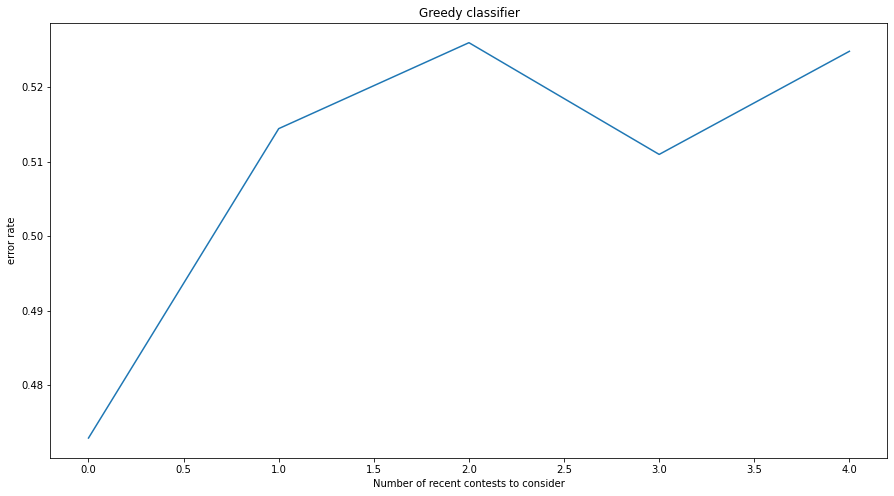

In [559]:
print("Best go_back:", go_backs[np.argmin(greedy_errors)], "error:", np.min(greedy_errors))
plt.figure(figsize=(15, 8))
plt.plot(go_backs, greedy_errors)
plt.title("Greedy classifier")
plt.xlabel("Number of recent contests to consider")
plt.ylabel("error rate")
plt.show()

Still random.

## Mean classifier

In [566]:
go_backs = list(range(5))
mean_errors = []

for go_back in go_backs:
    score, total = 0, 0
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        deltas = y_train[-go_back:]
        predictions = np.mean(deltas)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    mean_errors.append((total - score) / total)
    clear_output()

Best go_back: 0 error: 0.47750865051903113


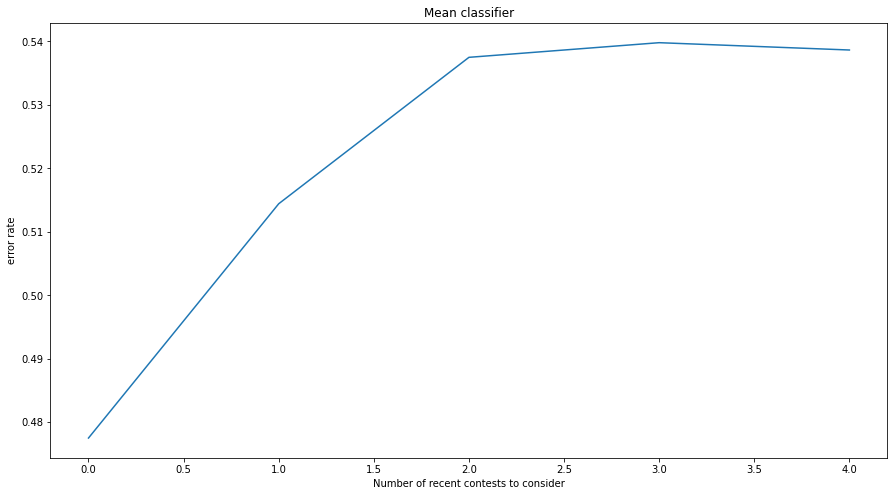

In [567]:
print("Best go_back:", go_backs[np.argmin(mean_errors)], "error:", np.min(mean_errors))
plt.figure(figsize=(15, 8))
plt.plot(go_backs, mean_errors)
plt.title("Mean classifier")
plt.xlabel("Number of recent contests to consider")
plt.ylabel("error rate")
plt.show()

Still random.

## KNNs

We will build model for every user and predict outcome of the last contest, as we want to predict performance based on user's previous performances.

### KNN (uniform weights)

Neighbors have the same weight no matter how far they are. Classifying is just computing the mean of K nearest neighbors.

In [483]:
from sklearn.neighbors import KNeighborsRegressor

ks = list(range(1, 21))
uniform_errors = []

for k in ks:
    score, total = 0, 0
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(k, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform").fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    uniform_errors.append((total - score) / total)
    clear_output()

Best K: 2 error: 0.48788927335640137


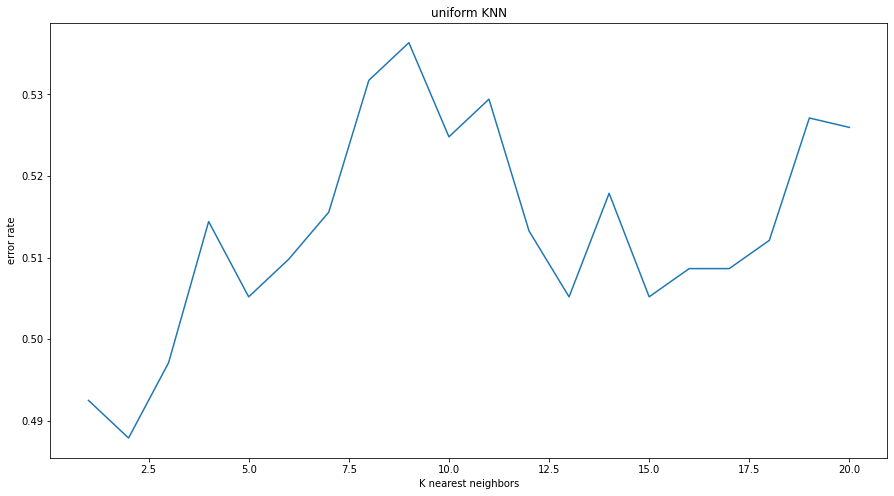

In [484]:
print("Best K:", ks[np.argmin(uniform_errors)], "error:", np.min(uniform_errors))
plt.figure(figsize=(15, 8))
plt.plot(ks, uniform_errors)
plt.title("uniform KNN")
plt.xlabel("K nearest neighbors")
plt.ylabel("error rate")
plt.show()

Althout we can calculate theoretically best K, we can see that errors, are pretty random, so it is not believable.

### KNN (weights inversely proportional to distance)

The same as above but we compute weighted mean, with weights inversely proportional to the distance between two points.

In [480]:
from sklearn.neighbors import KNeighborsRegressor

ks = list(range(1, 21))
distance_errors = []

for k in ks:
    score, total = 0, 0
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(k, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance").fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    distance_errors.append((total - score) / total)
    clear_output()

Best K: 3 error: 0.48788927335640137


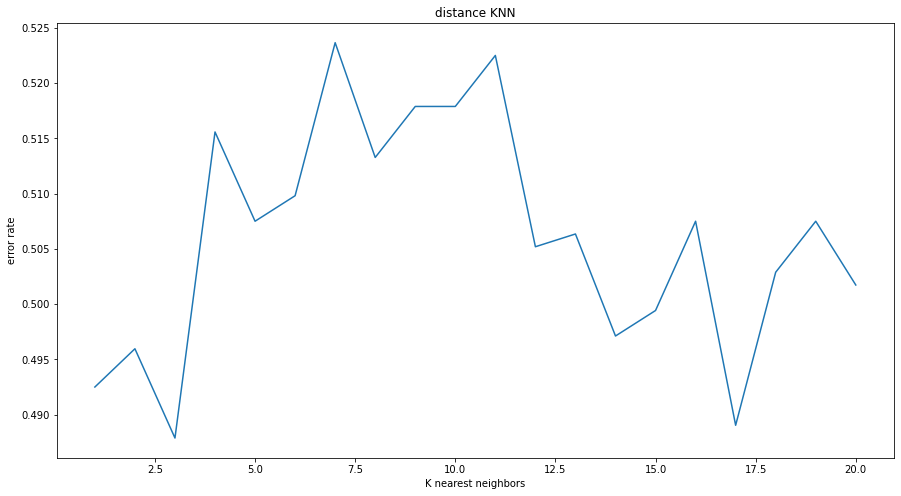

In [487]:
print("Best K:", ks[np.argmin(distance_errors)], "error:", np.min(distance_errors))
plt.figure(figsize=(15, 8))
plt.plot(ks, distance_errors)
plt.title("distance KNN")
plt.xlabel("K nearest neighbors")
plt.ylabel("error rate")
plt.show()

Same as above.

### KNN (custom distance metric)

Metric will be weighted distance with predefined weights for every coordinate - e.g. different influence of duration difference than of author correlation difference. 

#### Default weights

In [ ]:
XX = get_train_test()[0]

DEFAULT_OLD_RATING_WEIGHT = 1
DEFAULT_DAY_TIME_WEIGHT = 1
DEFAULT_DURATION_WEIGHT = 1
DEFAULT_START_TIME_WEIGHT = 1
DEFAULT_CORRELATION_WEIGHT = 1

weights = {
    "oldRating": DEFAULT_OLD_RATING_WEIGHT,
    "dayTime": DEFAULT_DAY_TIME_WEIGHT,
    "duration": DEFAULT_DURATION_WEIGHT,
    "startTime": DEFAULT_START_TIME_WEIGHT,
    "correlation": DEFAULT_CORRELATION_WEIGHT
}

# weights as vector in proper order
def get_weight_vector(weights):
    return np.array([weights[col] for col in XX.columns])

w = get_weight_vector(weights)

#### Individual parameter influence

##### oldRating weight influence

In [734]:
old_ratings = list(range(1, 10))
old_rating_errors = []

for old_rating in old_ratings:
    weights["oldRating"] = old_rating
    w = get_weight_vector(weights)
    custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 
    
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(5, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    old_rating_errors.append((total - score) / total)
    clear_output()
    
weights["oldRating"] = DEFAULT_OLD_RATING_WEIGHT
w = get_weight_vector(weights)

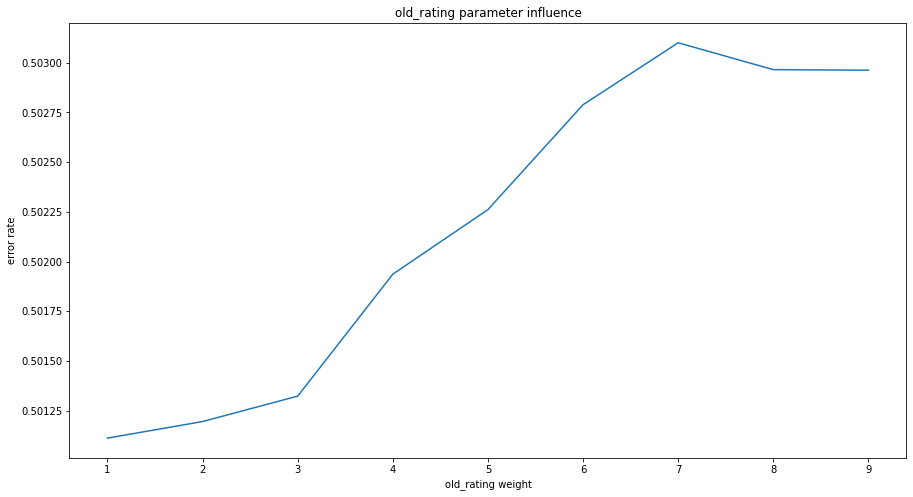

In [735]:
# print("Best K:", ks[np.argmin(distance_errors)], "error:", np.min(distance_errors))
plt.figure(figsize=(15, 8))
plt.plot(old_ratings, old_rating_errors)
plt.title("old_rating parameter influence")
plt.xlabel("old_rating weight")
plt.ylabel("error rate")
plt.show()

##### dayTime weight influence

In [732]:
day_times = list(range(1, 10))
day_time_errors = []

for day_time in day_times:
    weights["dayTime"] = day_time
    w = get_weight_vector(weights)
    custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 
    
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(5, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    day_time_errors.append((total - score) / total)
    clear_output()
    
weights["dayTime"] = DEFAULT_DAY_TIME_WEIGHT
w = get_weight_vector(weights)

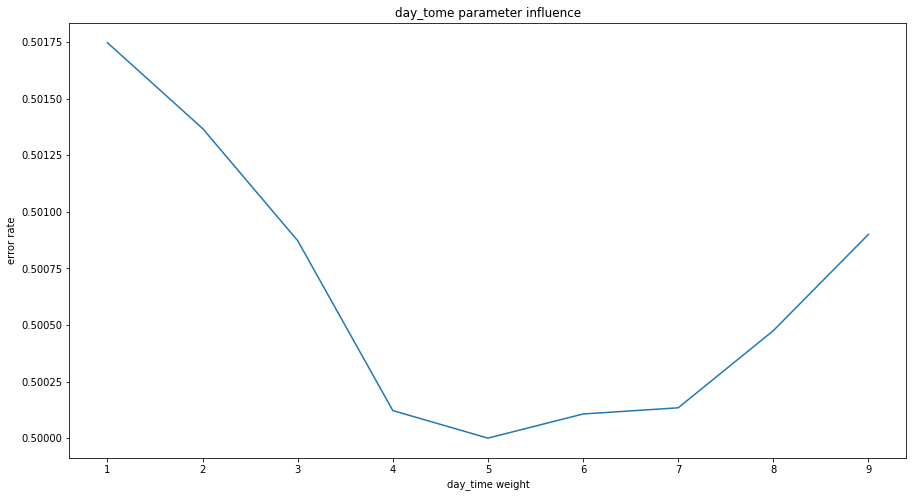

In [733]:
# print("Best K:", ks[np.argmin(distance_errors)], "error:", np.min(distance_errors))
plt.figure(figsize=(15, 8))
plt.plot(day_times, day_time_errors)
plt.title("day_time parameter influence")
plt.xlabel("day_time weight")
plt.ylabel("error rate")
plt.show()

##### duration weight influence

In [739]:
durations = list(range(1, 10))
duration_errors = []

for duration in durations:
    weights["duration"] = duration
    w = get_weight_vector(weights)
    custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 
    
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(5, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    duration_errors.append((total - score) / total)
    clear_output()
    
weights["duration"] = DEFAULT_DURATION_WEIGHT
w = get_weight_vector(weights)

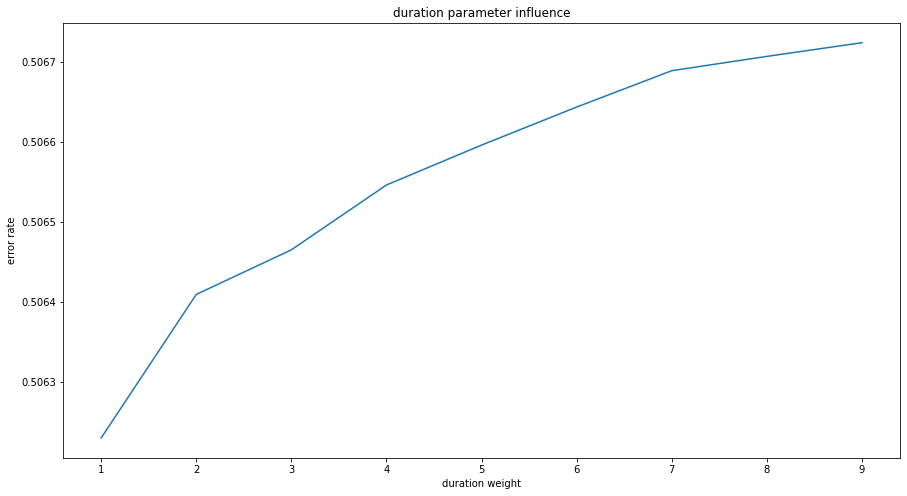

In [740]:
# print("Best K:", ks[np.argmin(distance_errors)], "error:", np.min(distance_errors))
plt.figure(figsize=(15, 8))
plt.plot(durations, duration_errors)
plt.title("duration parameter influence")
plt.xlabel("duration weight")
plt.ylabel("error rate")
plt.show()

##### startTime weight influence

In [741]:
start_times = list(range(1, 10))
start_time_errors = []

for start_time in start_times:
    weights["startTime"] = start_time
    w = get_weight_vector(weights)
    custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 
    
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(5, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    start_time_errors.append((total - score) / total)
    clear_output()
    
weights["startTime"] = DEFAULT_START_TIME_WEIGHT
w = get_weight_vector(weights)

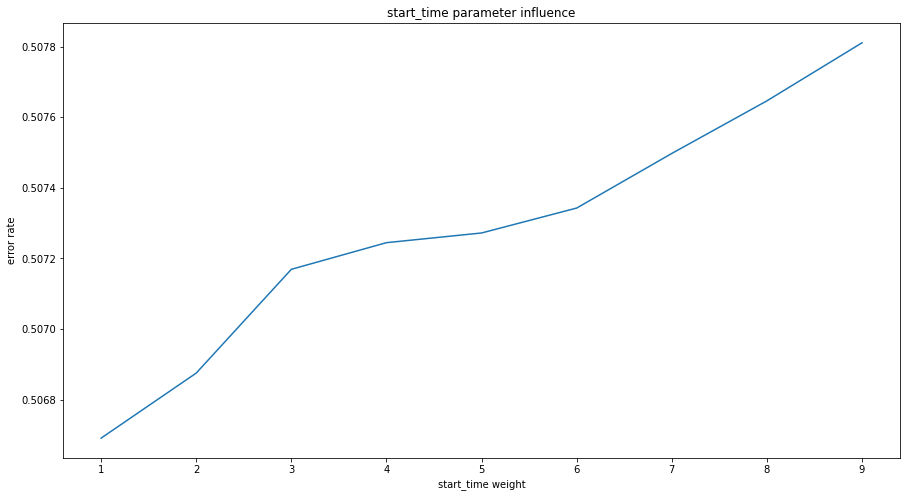

In [742]:
# print("Best K:", ks[np.argmin(distance_errors)], "error:", np.min(distance_errors))
plt.figure(figsize=(15, 8))
plt.plot(start_times, start_time_errors)
plt.title("start_time parameter influence")
plt.xlabel("start_time weight")
plt.ylabel("error rate")
plt.show()

##### correlation weight influence

In [737]:
correlations = list(range(1, 10))
correlation_errors = []

for correlation in correlations:
    weights["correlation"] = correlation
    w = get_weight_vector(weights)
    custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 
    
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(5, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    correlation_errors.append((total - score) / total)
    clear_output()
    
weights["correlation"] = DEFAULT_CORRELATION_WEIGHT
w = get_weight_vector(weights)

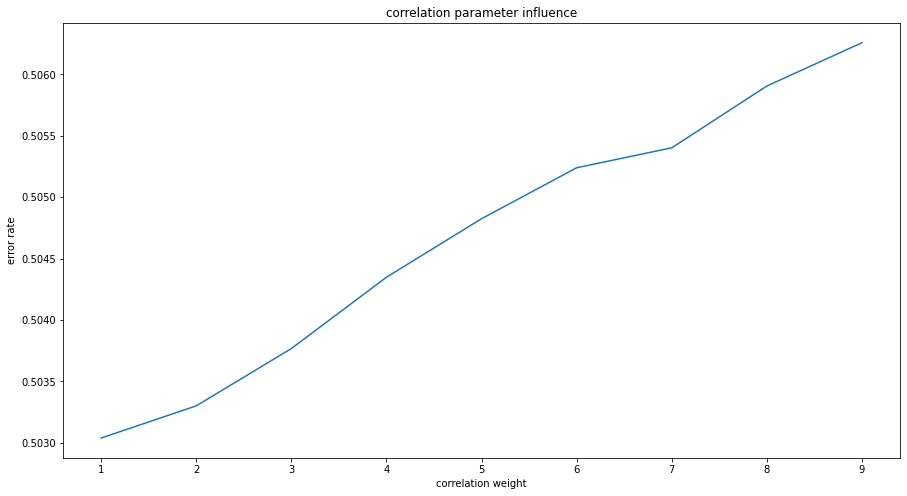

In [738]:
# print("Best K:", ks[np.argmin(distance_errors)], "error:", np.min(distance_errors))
plt.figure(figsize=(15, 8))
plt.plot(correlations, correlation_errors)
plt.title("correlation parameter influence")
plt.xlabel("correlation weight")
plt.ylabel("error rate")
plt.show()

#### Weights "found" by individual analysis

In [765]:
weights["oldRating"] = 1
weights["dayTime"] = 5
weights["duration"] = 1
weights["startTime"] = 1
weights["correlation"] = 1

w = get_weight_vector(weights)
custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 

score, total = 0, 0
for handle in tqdm(users):
    X_train, X_test, y_train, y_test = get_train_test(handle=handle)
    n_neighbors = min(5, X_train.shape[0])
    model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
    predictions = model.predict(X_test)
    score += np.sum(np.sign(predictions) == np.sign(y_test))
    total += y_test.shape[0]

print("Score:", score / total)

100%|██████████| 867/867 [00:14<00:00, 59.00it/s]

Score: delta    0.50173
dtype: float64


#### Finding optimal weights with scipy

In [762]:
from scipy.optimize import minimize

def f_error(w):
    weights["oldRating"] = w[0]
    weights["dayTime"] = w[1]
    weights["duration"] = w[2]
    weights["startTime"] = w[3]
    weights["correlation"] = w[4]
    w = get_weight_vector(weights)
    custom_metric = lambda e1, e2: np.sqrt(np.sum(w * (e1 - e2) ** 2)) 
    
    score, total = 0, 0
    for handle in tqdm(users):
        X_train, X_test, y_train, y_test = get_train_test(handle=handle)
        n_neighbors = min(5, X_train.shape[0])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, metric=custom_metric).fit(X_train, y_train)
        predictions = model.predict(X_test)
        score += np.sum(np.sign(predictions) == np.sign(y_test))
        total += y_test.shape[0]
    
    return (total - score) / total

In [763]:
x0 = np.array([1, 1, 1, 1, 1])
opt = minimize(f_error, x0)
opt

100%|██████████| 867/867 [00:12<00:00, 69.45it/s]


      fun: 0.5051903114186851
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 1., 1., 1., 1.])

In [764]:
x0 = np.array([1, 5, 1, 1, 1])
opt = minimize(f_error, x0)
opt

100%|██████████| 867/867 [00:12<00:00, 70.53it/s]


      fun: 0.4982698961937716
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 5., 1., 1., 1.])

Unfortunately search ends with failure. We are where we started.

## Conclusions

From tests carried out, KNN is probably not the best choice for rating change prediction task. If there is any relation between the data it is hard to spot it with KNN algorithm. It requires a lot of data, which is pretty hard to find considering that VERY active users have around 100 contests. On the other hand considering users jointly won't give good results as performance of user is individual.